# King County Housing Sale Price Indicators

In [3]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## The Data

For this project, I used 4 data sets:
- EXTR_LookUp.csv
- EXTR_Parcel.csv
- EXTR_ResBldg.csv
- EXTR_RPSale.csv

### Observations
There are three main data tables and one look up data table. Extra_RPSale.csv is the lengthiest data set as it contains transactions for any property that has occured in King County. Following this is EXTR_Parcel.csv. This data set give various facts about any parcel of land and fact pertaining to this such as topographical features. The third data set is EXTR_ResBldg.csv. This data set contains many fields of interest since it pertains to facts of residential properties such as room, bath count, and square footage.

### Cleaning
After carefully filtering out obsolete columns, I proceeded to ensure that all the data types were in the correct form and that incomplete fields were taken care of. I merged all the data sets using the unique major + minor identification, and filtered data from 2019 that pertained to residential properties. I also refrenced the pdf dictionary to use the look up data set to fill in all unknown numerical parameters. This is the processed dataframe.

In [6]:
df = pd.read_csv('../../../data/processed/kc_clean_data.csv')
df.head()

,Unnamed: 0,nbr_living_units,building_number,stories,bldg_grade,sq_ft1st_floor,sq_ft_half_floor,sq_ft2nd_floor,sq_ft_upper_floor,sq_ft_unfin_full,...,water_system,sewer_system,inadequate_parking,pcnt_unusable,unbuildable,nbr_bldg_sites,contamination,water_problems,sale_price,year
0,0,1,2435,1.0,7 Average,1480,0,0,0,0,...,WATER DISTRICT,PUBLIC,ADEQUATE,0,False,0,0,N,311000,2019
1,1,1,12254,1.0,5 Fair,550,0,0,0,0,...,WATER DISTRICT,PRIVATE,ADEQUATE,0,False,0,0,N,188500,2019
2,2,1,1602,2.0,9 Better,660,0,595,0,0,...,WATER DISTRICT,PUBLIC,0,0,False,0,0,N,730000,2019
3,3,1,3410,2.0,9 Better,1602,0,1991,0,0,...,WATER DISTRICT,PUBLIC,ADEQUATE,0,False,0,0,N,888679,2019
4,4,1,4512,1.0,8 Good,2290,0,0,0,0,...,WATER DISTRICT,PUBLIC,ADEQUATE,0,False,0,0,N,800000,2019


## Modeling

I started off by creating a heatmap of the correlation matrix and also listing the various correlations for sale_price. Despite almost every indicator producing a weak correlation coefficient, I decided to use the total sq ft of living space as the first indicator for the base model.

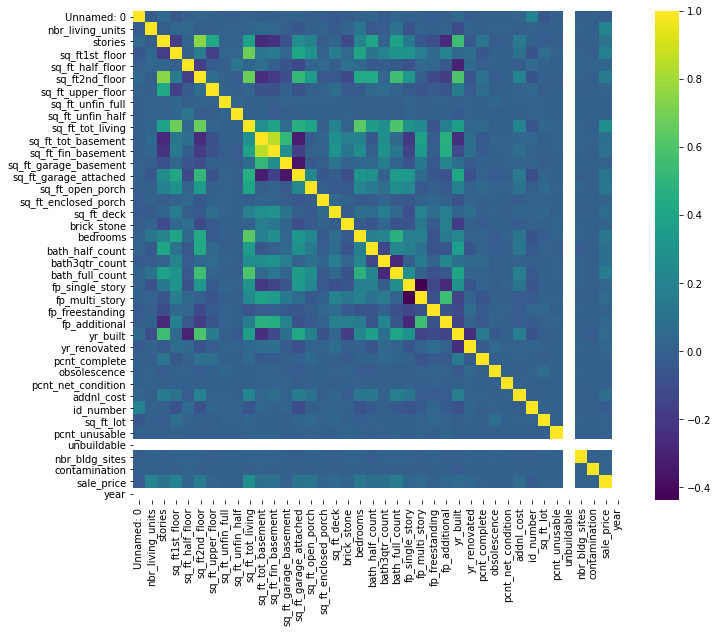

In [49]:
corr = df.corr()
fig1, ax1 = plt.subplots(figsize = (11,9))
sns.heatmap(corr, ax = ax1, cmap = "viridis")
plt.savefig('heatmap.png')

In [8]:
corr_matrix = df.corr()
corr_matrix.sale_price.sort_values(ascending=True)

id_number               -0.026026
Unnamed: 0              -0.016572
pcnt_net_condition      -0.002847
sq_ft_unfin_half        -0.001626
obsolescence            -0.000482
sq_ft_unfin_full         0.000322
sq_ft_garage_basement    0.001356
pcnt_unusable            0.002040
sq_ft_lot                0.006410
pcnt_complete            0.007330
fp_freestanding          0.009060
nbr_bldg_sites           0.010367
sq_ft_upper_floor        0.021832
contamination            0.022773
sq_ft_enclosed_porch     0.025241
sq_ft_half_floor         0.025268
brick_stone              0.025800
fp_single_story          0.032339
yr_renovated             0.036809
fp_additional            0.039284
yr_built                 0.051984
fp_multi_story           0.053827
sq_ft_deck               0.058800
addnl_cost               0.065168
sq_ft_tot_basement       0.080013
bath_half_count          0.084829
bath3qtr_count           0.085890
sq_ft_fin_basement       0.092085
stories                  0.108344
sq_ft_garage_a

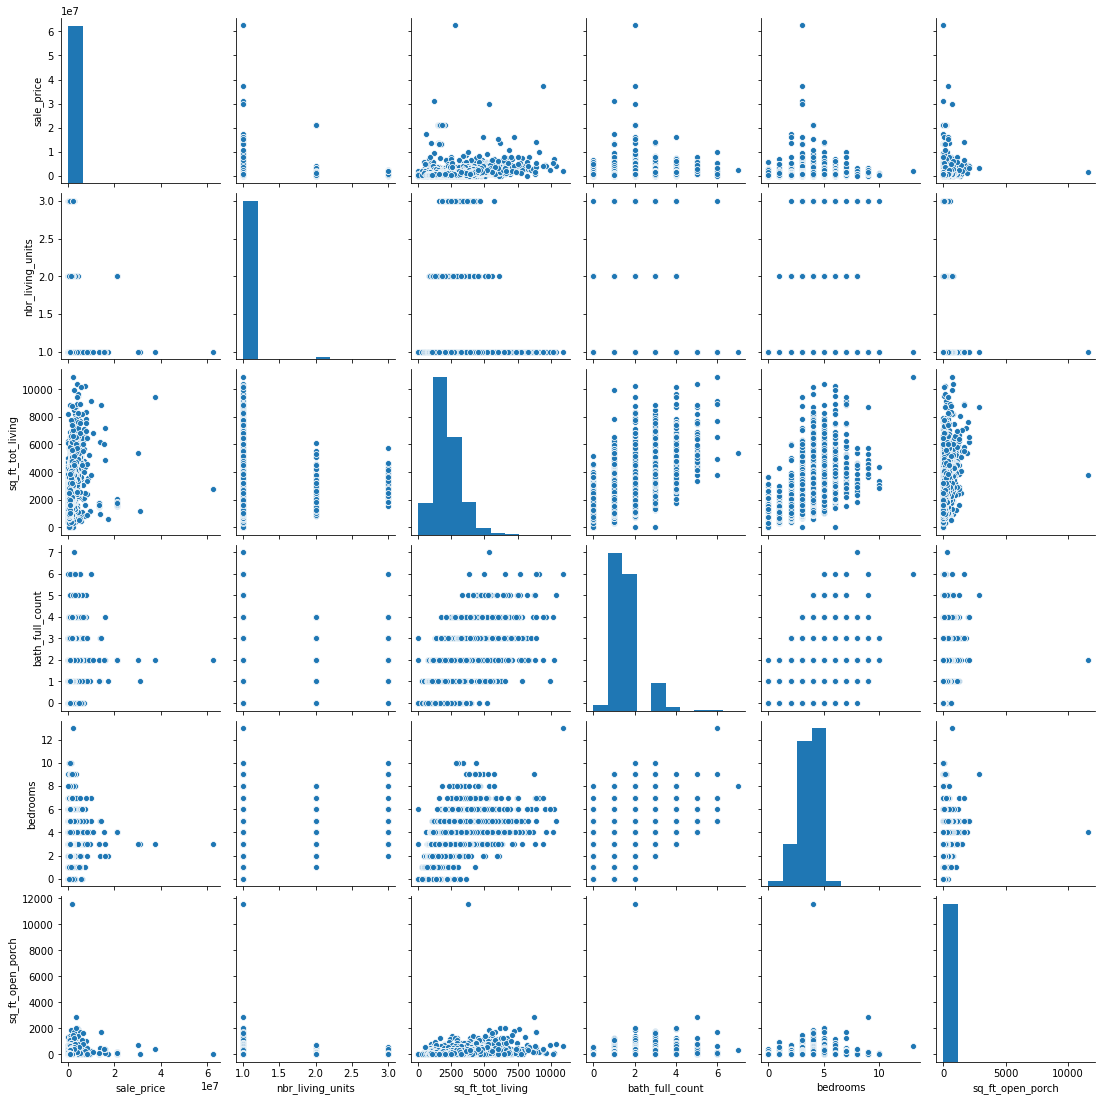

In [30]:
positively_correlated_cols = ['sale_price', 'nbr_living_units', 'sq_ft_tot_living', 'bath_full_count',
                              'bedrooms','sq_ft_open_porch']
positively_correlated_df = df[positively_correlated_cols]
sns.pairplot(positively_correlated_df);

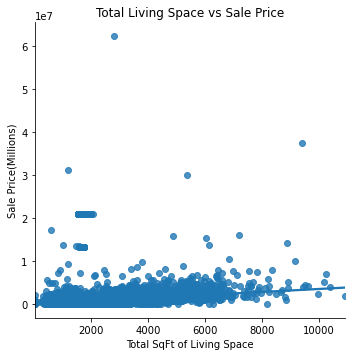

In [48]:
sns.lmplot(data = df, x = 'sq_ft_tot_living', y = 'sale_price')
plt.xlabel('Total SqFt of Living Space')
plt.ylabel('Sale Price(Millions)')
plt.title('Total Living Space vs Sale Price')
plt.savefig('livingsp-price.png')

### Base Model

This model R2 value was very low to begin with, but this was expected given the weak correlation values to start off with. Based on the plot, there seemed to be no transformation to improve this.

In [24]:
bm_df = df[['sq_ft_tot_living', 'sale_price']].copy()
bm_df.dropna(inplace = True)

In [25]:
base_model = ols(formula = 'sale_price ~ sq_ft_tot_living', data = bm_df)
base_model_results = base_model.fit()

In [26]:
base_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2062.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        06:14:58   Log-Likelihood:            -4.4316e+05
No. Observations:               28637   AIC:                         8.863e+05
Df Residuals:                   28635   BIC:                         8.863e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.148e+05   1.82e+04      6.292      0.000     7.9e+04    1.51e+05
sq_ft_tot_living   346.3829      7.628     45.410      0.000     331.432     361.334
==============================================================================
Omnibus:                    56748.786   Durbin-Watson:                   1.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        175084045.110
Skew:                          16.058   Prob(JB):                         0.00
Kurtosis:                     384.710   Cond. No.                     5.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Testing Base Model
In order to check various assumptions for the linear model, I preformed the rainbow test, het breuschpagan test, and observed the VIF. I also plotted the regression to check homoscedasticity and referes to the Jarque_Bera variable. For efficiency, I created functions for each test.

In [27]:
#testing linearity
def rainbow_(model_results):
    rainbow_statistic, rainbow_p_value = linear_rainbow(model_results)
    print("Rainbow Statistic: ", rainbow_statistic)
    print("Rainbow P-Value: ", rainbow_p_value)
    
def homoscad_(model_results, model_df, het_b = None):
    y = model_df['sale_price']
    y_hat = model_results.predict()
    fig2, ax2 = plt.subplots()
    ax2.set(xlabel = 'Predicted Sales Prices', ylabel = 'Residuals(Predicted - Actual)')
    ax2.scatter(x = y_hat, y = y_hat - y, color = "red", alpha = 0.1);
    if het_b:
        lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y - y_hat, model_df[het_b])
        print('Lagrange Multiplier P-Value: ', lm_p_value)
        print('F-Statistic P-Value', f_p_value)
        
def independance_(model_df, model_features):
    rows = model_df[model_features].values
    vif_df = pd.DataFrame()
    vif_df['VIF'] = [variance_inflation_factor(rows, i) for i in range(len(model_features))]
    return vif_df

In [28]:
rainbow_(base_model_results)

Rainbow Statistic:  0.36911395983441064
Rainbow P-Value:  0.9999999999999999


Lagrange Multiplier P-Value:  nan
F-Statistic P-Value 3.0542274792624994e-17


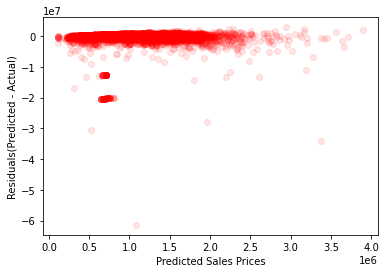

In [29]:
homoscad_(base_model_results, bm_df, ['sq_ft_tot_living'])

### Final Model
After testing out various more models, it seemed that less indicators would be the best solution in this case, given how weak the original correlation coefficients were for all the parameters. For my final model, I used three indicators, total sq feet of living space, sq feet of garage attached, and sq feet of open porch. These pointers also allow me to gain insight into the original target questions. Not only does this model pass some tests, but it also has lower VIF values so these pointers seem to be fairly independant.

In [33]:
final_features = ['sq_ft_tot_living', 'sq_ft_open_porch', 'sq_ft_garage_attached']
final_df = df[['sale_price','sq_ft_tot_living', 'sq_ft_open_porch', 'sq_ft_garage_attached']].copy()

In [35]:
final = ols(formula = 'sale_price ~ sq_ft_tot_living + sq_ft_open_porch + sq_ft_garage_attached', data = final_df)
final_results = final.fit()

In [36]:
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     696.3
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        06:22:23   Log-Likelihood:            -4.4315e+05
No. Observations:               28637   AIC:                         8.863e+05
Df Residuals:                   28633   BIC:                         8.863e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               1.27e+05   1.85e+04      6.874      0.000    9.08e+04    1.63e+05
sq_ft_tot_living        336.3978      9.219     36.491      0.000     318.329     354.467
sq_ft_open_porch        274.0864     56.705      4.834      0.000     162.942     385.231
sq_ft_garage_attached   -45.9457     29.615     -1.551      0.121    -103.992      12.101
==============================================================================
Omnibus:                    56807.337   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        176166666.037
Skew:                          16.095   Prob(JB):                         0.00
Kurtosis:                     385.890   Cond. No.                     5.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Although the R2 value only slightly improves, this is still considerable improvement given how low R2 was even using the most correlated pointer. The top pointers actually had high VIF values so even though they yielded higher r2 values in unison, it was a clear violation of a linear assumption.
#### Testing Final Model
I also subjected this model to the series of tests for linear assumptions.

In [40]:
rainbow_(final_results)

Rainbow Statistic:  0.3694693388777271
Rainbow P-Value:  0.9999999999999999


Lagrange Multiplier P-Value:  1.0266384891050928e-22
F-Statistic P-Value 7.649266171003396e-22


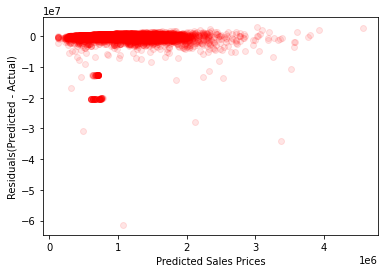

In [41]:
homoscad_(final_results, final_df, final_features)

In [39]:
independance_(final_df, final_features)

,VIF
0,2.799973
1,1.517915
2,2.374730


The VIF test shows that this data leans towards the independant side. Given how weakly correlated the pointers are to the sale price, it is natural that the other test failed, and it was progress to at least mitigate the test results. This model covers the variance in almost 7% of the data, and my conclusions will be based off of this.

## Conclusions
First, I would like to point back to the original questions:
- Enclosing a porch will increase the sale price of a home
- Converting a garage to a bedroom is a good way to increase the sale price of a home
- Upgrading to a forced-air heating system will increase the sale price of a home

According to my findings using this linear regression model which explains about 7% of the variation in sales prices in King County, enclosing a porch will increase the value of a home between 162 to 385 dollars within  a 95% confidence interval for every sq foot of porch space added. Additionally, according to the model, coverting a garage to a living space may increase the value of the home. My evidence for this that the model shows that for every sq foot of garage space that is attached, the home value will depreciate by 46 dollars. However, since the 95% confidence interval shows that there is a possibility that every sq foot of garage space may increase home value by up to 12 dollars, I am unable to report any reccomendation conclusively regarding garage space. However, fundementally, this model shows that for every sq ft of living space, the sale price will increase by about 336 dollars. Since the parameters of this model do not include the nature of the heating system, I am unable to report any findings about the impact of a force-air heating system on the sale price of a home.

My clear reccomendations to home owners are to increase living space and porch space as they can increase the sale price of a home based on the results of the model. However, with such low correlations, my advice for homeowners seeking to renovate homes are to seriously weight the cost of creating renovations, as the lack of a strong correlation may not justify such an expenditure.

## Next Steps
This data only considers data from 2019, I would like to manipulate the data from 2020 and 2021 since the housing market has undergone more changes. Furthermore I would like to provide analysis on the average cost of home improvements to gain a better insight on wether I could reccomend a home owner to do so. More analysis is required on the present data to better clean and evaluate certain underlying trends such as the impact of heating systems.